# Import Statements

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from copy import deepcopy
import numpy as np
import statsmodels.api as sm
import random
import ast

from graph_util.visualization_util import make_graph_visual
from scheduling_util.modified_etf import Mod_ETF
from scheduling_util.consolidated_functions import opt_schedule_given_ordering
from scheduling_util.heuristics import *
from graph_util.random_graph_functions import random_all_fork, random_all_join
from graph_util.erdos_renyi_dag import er_dag
from scheduling_util.approx_pseudosizes import speed_to_psize

# ***EDIT: Set Global Parameters

Edit basic parameters here. Nothing else needs to be altered to produce plots.

In [2]:
training_data_filename = "example_training_data.csv"
testing_data_filename = "example_testing_data.csv"
num_machines = 2

# Training Data

In [3]:
feature_id = ['constant', 'num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels']    

# Function to get list of feature sets. A feature set is in the form [x1, x2, ..., y] where y is psize
def get_feature_set(G):
    lst = []
    
    # Get attributes for graph G
    out_bet_lst = nx.algorithms.out_degree_centrality(G)
    trophic_lst = nx.algorithms.trophic_levels(G)
    
    # Create feature set for each node in G
    for node in G.nodes:
        out_bet = out_bet_lst[node]
        trophic = trophic_lst[node]
        descendants = list(nx.algorithms.dag.descendants(G, node))
        descendants.append(node)
        
        lst.append({
            "constant": 1,
            "num_descendants": float(len(descendants)),
            "out_degree_betweenness_centrality": float(out_bet),
            "trophic_levels": float(trophic),
        })   
        
    return lst

Create training data with given parameters

In [4]:
def reset_psizes(psizes):
    revised_lst = [abs(x) for x in psizes]
    assert(all([z > 0 for z in revised_lst]))
    return revised_lst

# Function to create dataset
def create_dataset(num_machines, csv_file):
    
    df = pd.DataFrame(columns = [
        "graph_object",
        "num_tasks",
        "num_machines",
        "weights",
        "order",
        "features",
        "psize",
        "GD_cost",
        "LR_cost",
        "RLP_cost",
        "ETF-H_cost",
        "weak_strongman_cost"
    ])
    tie_breaking_rule = 2
    count = 0

    csv_df = pd.read_csv(csv_file) 
    for index, row in csv_df.iterrows():
        
        dict_dag = ast.literal_eval(row["graph_object"])
        G = nx.node_link_graph(dict_dag)

        num_tasks = len(G)
        
        _, _, h1_cost, _ = heuristic_algorithm(G, num_machines)
        w = [1 for _ in range(num_tasks)]
        s = [1 for _ in range(num_tasks)]
        p = [1 for _ in range(num_tasks)]
        etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
        weak_strongman_cost = naive_2(G, num_machines)
        intervals, speeds, opt_cost = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
        if speeds[0] != -1:
            entry_dict = {
                "graph_object": nx.node_link_data(G),
                "num_tasks": num_tasks,
                "num_machines": num_machines,
                "weights": w,
                "order": etf.order,
                "features": get_feature_set(G),
                "psize": speed_to_psize(speeds),
                "GD_cost": np.inf,
                "LR_cost": np.inf,
                "RLP_cost": opt_cost,
                "ETF-H_cost": h1_cost,
                "weak_strongman_cost": weak_strongman_cost
            }
            df = df.append(entry_dict, ignore_index = True)
                    
    return df


In [5]:
df_train = create_dataset(num_machines, training_data_filename)
df_train

,graph_object,num_tasks,num_machines,weights,order,features,psize,GD_cost,LR_cost,RLP_cost,ETF-H_cost,weak_strongman_cost
0,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 4, 7, 8, 6], [1, 3, 5, 2, 9]]","[{'constant': 1, 'num_descendants': 6.0, 'out_...","[5.000009044899999, 5.000009044899999, 1.99998...",inf,inf,33.52933,33.529329,33.979048
1,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[2, 4, 3, 7, 5], [0, 1, 6, 9, 8]]","[{'constant': 1, 'num_descendants': 6.0, 'out_...","[5.000009044899999, 3.9999600000999997, 4.9999...",inf,inf,33.52933,33.529329,34.023323
2,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 1, 7, 3, 9], [2, 4, 5, 8, 6]]","[{'constant': 1, 'num_descendants': 6.0, 'out_...","[5.000053766399999, 4.0000400001, 4.9999643236...",inf,inf,33.52933,33.529329,34.276576
3,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[2, 1, 3, 7, 8], [4, 0, 5, 6, 9]]","[{'constant': 1, 'num_descendants': 4.0, 'out_...","[4.0, 4.0, 5.000009044899999, 2.99999720250000...",inf,inf,33.52933,33.529329,33.886471


# Train Model

In [6]:
def compute_cost(w, t, s):
    '''
    Given weights w, time intervals t, and speeds s, compute the cost of the schedule; 
    returns total cost as well as separate power and time components.
    '''
    power = 0
    time = 0
    #print(f"compute cost intervals are {t}")
    for j in range(len(s)):
        if t[j] == -1:
            return -1, -1, -1
        power += w[j] * s[j]
        time += t[j][1]
    total_cost = power + time
    return total_cost, power, time

def psize_to_speed(psize):
    return [np.sqrt(psize[i]) for i in range(len(psize))]

#predict list of psizes for one graph G
def predict(coef, features):
    m = []
    for f in features:
        m.append(list(f.values()))
    return np.matmul(m, coef)

Train Linear Regression

In [7]:
# Create X, Y dataset
df_features = pd.DataFrame(columns = feature_id)
df_psize = pd.DataFrame(columns = ["psize"])
for index, row in df_train.iterrows():
    for feature in row["features"]:
        df_features = df_features.append(feature, ignore_index=True)
    for psize in row["psize"]:
        df_psize = df_psize.append({"psize": psize}, ignore_index=True)   
X = df_features[feature_id]
Y = df_psize[["psize"]]
model=sm.OLS(Y, X.astype(float)).fit()
print_model=model.summary()
print(print_model)

# weights learned from LR
lr_coefficients = np.array(model.params)
print(lr_coefficients)


                            OLS Regression Results                            
Dep. Variable:                  psize   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     63.89
Date:                Mon, 28 Mar 2022   Prob (F-statistic):           1.72e-14
Time:                        20:14:40   Log-Likelihood:                -33.733
No. Observations:                  40   AIC:                             75.47
Df Residuals:                      36   BIC:                             82.22
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
consta

In [8]:
lr_lst = []

for index, row in df_train.iterrows():
    # predict using LR model
    psizes = reset_psizes(predict(lr_coefficients, row["features"]))
    speeds = psize_to_speed(psizes)
    G = nx.node_link_graph(row["graph_object"])
        
    time_intervals = native_rescheduler(deepcopy(G), deepcopy(speeds), deepcopy(row["weights"]), deepcopy(row["order"]))
    cost, power, time = compute_cost(row["weights"], time_intervals, speeds)
    lr_lst.append(cost)
    
# update costs
new_df = pd.DataFrame({'LR_cost': lr_lst})
df_train.update(new_df)

# for initialization purposes only
new_df = pd.DataFrame({'GD_cost': lr_lst})
df_train.update(new_df)


Train Gradient Descent

In [9]:
# Functions for Gradient Descent Approach
def single_weight_update(coef, G, w, features, order, curr_cost, step_size):
    
    m = []
    for f in features:
        m.append(list(f.values()))
        
    curr_min_coef = deepcopy(coef)
    min_cost = curr_cost
    all_combinations = list(product((-1, 1, 0), repeat=len(coef)))
    for combo in all_combinations:
        temp_coef = deepcopy(coef)
        for i in range(len(combo)):
            temp_coef[i] += step_size * combo[i]
        psizes = reset_psizes(np.matmul(m, temp_coef))
        speeds = psize_to_speed(psizes)
        time_intervals = native_rescheduler(deepcopy(G), deepcopy(speeds), deepcopy(w), deepcopy(order))
        cost, _, _ = compute_cost(w, time_intervals, speeds)
        if cost < min_cost:
            min_cost = cost
            curr_min_coef = deepcopy(temp_coef)
        
    return min_cost, curr_min_coef



In [10]:
def gd_algorithm(lr_coefficients, df):
    MAX_ITER = 1000
    step_size = 0.05
    i = 0
    
    coef = lr_coefficients

    stopping_condition = 0.001

    #iterate until the objective function cost change lowers to stopping point
    while i < MAX_ITER:

        cost_lst = []
        max_change = - np.infty
        for index, row in df.iterrows():
            new_cost, new_coef = single_weight_update(
                coef, 
                nx.node_link_graph(row["graph_object"]),
                row["weights"], 
                row["features"], 
                row["order"],
                row["GD_cost"],
                step_size
            )

            if row["GD_cost"] == np.inf: 
                change = - np.inf

            else:
                change = row["GD_cost"] - new_cost

            cost_lst.append(new_cost)
            max_change = max(change, max_change)
            coef = new_coef
        print(max_change)

        # update costs
        new_df = pd.DataFrame({'GD_cost': cost_lst})
        df.update(new_df)
        if max_change < stopping_condition and i > 1:
            print("Hit stopping condition with ", max_change)
            break
        i += 1
    
    return df, coef

In [11]:
df_train_results, coef_train = gd_algorithm(lr_coefficients, df_train)

0.10488934674933148
0.0027570478964875633
0.07239593041084191
0.03364665209601725
0.011757617135302212
0.004569222745182344
0.004415888226738218
0.004264657819703643
0.0020762645205962826
0.01610410526604511
0.012353044798366852
0.01307996538196221
0.014095814412797836
0.012034862853802508
0.012131959678647775
0.013314613469859182
0.01159746316237431
0.013074669731338417
0.01245607280626615
0.01018921366745218
0.01318987762880397
0.011717053867243976
0.008580212380195462
0.00601796138738564
0.005718806020780676
0.009687064646669796
0.0020447489056039103
0.0014914366559537484
0.0029371929956170106
0.0007834220811702153
Hit stopping condition with  0.0007834220811702153


In [12]:
df_train_results

,graph_object,num_tasks,num_machines,weights,order,features,psize,GD_cost,LR_cost,RLP_cost,ETF-H_cost,weak_strongman_cost
0,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 4, 7, 8, 6], [1, 3, 5, 2, 9]]","[{'constant': 1, 'num_descendants': 6.0, 'out_...","[5.000009044899999, 5.000009044899999, 1.99998...",33.712671,34.153326,33.52933,33.529329,33.979048
1,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[2, 4, 3, 7, 5], [0, 1, 6, 9, 8]]","[{'constant': 1, 'num_descendants': 6.0, 'out_...","[5.000009044899999, 3.9999600000999997, 4.9999...",33.742380,33.772807,33.52933,33.529329,34.023323
2,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 1, 7, 3, 9], [2, 4, 5, 8, 6]]","[{'constant': 1, 'num_descendants': 6.0, 'out_...","[5.000053766399999, 4.0000400001, 4.9999643236...",33.672350,33.686407,33.52933,33.529329,34.276576
3,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[2, 1, 3, 7, 8], [4, 0, 5, 6, 9]]","[{'constant': 1, 'num_descendants': 4.0, 'out_...","[4.0, 4.0, 5.000009044899999, 2.99999720250000...",33.733295,33.821014,33.52933,33.529329,33.886471


In [13]:
print(lr_coefficients)

print(coef_train)

[ 2.84150396  0.38681543  1.96944747 -0.65857573]
[ 1.49150396  0.73681543  3.86944747 -0.40857573]


# Set Trained Coefficients to linear model

# Test the Model

This section tests the model using the coefficients found above.

In [14]:
# parameters

count = 0

df_test = create_dataset(num_machines, testing_data_filename)

lr_lst = []
gd_lst = []

for index, row in df_test.iterrows():
    # predict using LR model
    psizes_lr = reset_psizes(predict(lr_coefficients, row["features"]))
    speeds_lr = psize_to_speed(psizes_lr)
    G = nx.node_link_graph(row["graph_object"])
    time_intervals_lr = native_rescheduler(deepcopy(G), deepcopy(speeds_lr), deepcopy(row["weights"]), deepcopy(row["order"]))
    cost_lr, power_lr, time_lr = compute_cost(row["weights"], time_intervals_lr, speeds_lr)
    lr_lst.append(cost_lr)

# update costs
new_df_lr = pd.DataFrame({'LR_cost': lr_lst})
df_test.update(new_df_lr)


In [15]:
#print-out shows objective function value change
df_results, coef_test = gd_algorithm(lr_coefficients, df_test)

-inf
0.007430005220008695
0.47598338906359317
0.0028412844037006835
0.0025904496551305556
0.00234447788898251
0.002103244843368657
0.0018666303101184667
0.0016345179732581983
0.0014067952550433915
0.0011833531692460042
0.0009640861812414414
Hit stopping condition with  0.0009640861812414414


# Visual confirmation of costs

The printout below provides a visual confirmation of the objective function value costs resulting from each candidate algorithm.


In [16]:
df_results

,graph_object,num_tasks,num_machines,weights,order,features,psize,GD_cost,LR_cost,RLP_cost,ETF-H_cost,weak_strongman_cost
0,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[3, 1, 4, 6, 7, 9], [0, 2, 5, 8]]","[{'constant': 1, 'num_descendants': 6.0, 'out_...","[5.000009044899999, 4.0, 4.0, 5.00000904489999...",34.338205,34.379545,34.16500,34.165004,34.038656
1,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[1, 2, 6, 5, 7, 9], [0, 4, 3, 8]]","[{'constant': 1, 'num_descendants': 2.0, 'out_...","[5.000009044899999, 5.000009044899999, 4.0, 2....",35.287464,35.783634,34.70090,34.700902,33.906203
2,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 1, 4, 5, 6, 8], [2, 3, 7, 9]]","[{'constant': 1, 'num_descendants': 9.0, 'out_...","[8.1049534864, 7.104943560099999, 1.8950550920...",34.692536,35.537204,34.38235,36.139805,37.213256
3,"{'directed': True, 'multigraph': False, 'graph...",10,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[0, 4, 3, 6, 8, 9], [2, 1, 5, 7]]","[{'constant': 1, 'num_descendants': 7.0, 'out_...","[5.000009044899999, 4.0002800049000005, 5.0000...",34.614028,34.597704,34.35776,34.357757,35.041695


# ***EDIT: Graph the results

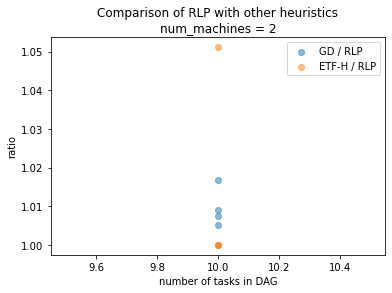

In [17]:
plt.scatter(df_results["num_tasks"], df_results["GD_cost"] / df_results["RLP_cost"], label='GD / RLP', alpha=0.5)
plt.scatter(df_results["num_tasks"], df_results["ETF-H_cost"] / df_results["RLP_cost"], label='ETF-H / RLP', alpha=0.5)
plt.title("Comparison of RLP with other heuristics\nnum_machines = 2")
plt.xlabel("number of tasks in DAG")
plt.ylabel("ratio")
plt.legend()

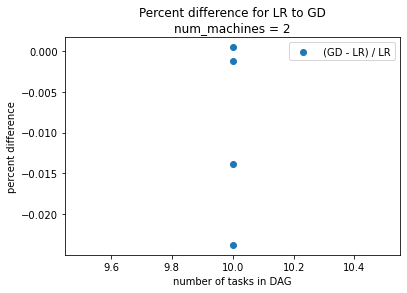

In [18]:
plt.scatter(df_results["num_tasks"], (df_results["GD_cost"]- df_results["LR_cost"] )/ df_results["LR_cost"], label=' (GD - LR) / LR')
plt.title("Percent difference for LR to GD\nnum_machines = 2")
plt.xlabel("number of tasks in DAG")
plt.ylabel("percent difference")
plt.legend()
